# Strategy 

In this dataset, features are masked (numerically encoded) or categorical. Number of years in current city could be numeric but beyond 4 years, input values are '4+'.

The following discrete features are <u> numerically encoded </u> therefore we shall use one-hot encoding scheme:
- User_ID
- Occupation
- Marital_Status
- Product_Category_1, Product_Category_2, Product_Category_3

The following discrete features are 	<u> categorical </u> thus we need to binarize them (numeric then one-hot encoding):
- Product_ID
- Gender
- Age
- City_Category
- Stay_In_Current_City_Years

In [1]:
import pandas as pd
filename = './data/raw/train_oSwQCTC/train.csv'
df = pd.read_csv(filename)

In [2]:
df.dtypes

User_ID                         int64
Product_ID                     object
Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Product_Category_3            float64
Purchase                        int64
dtype: object

## Correlation
Let's see what correlation between features tells us before going further

<IPython.core.display.Javascript object>


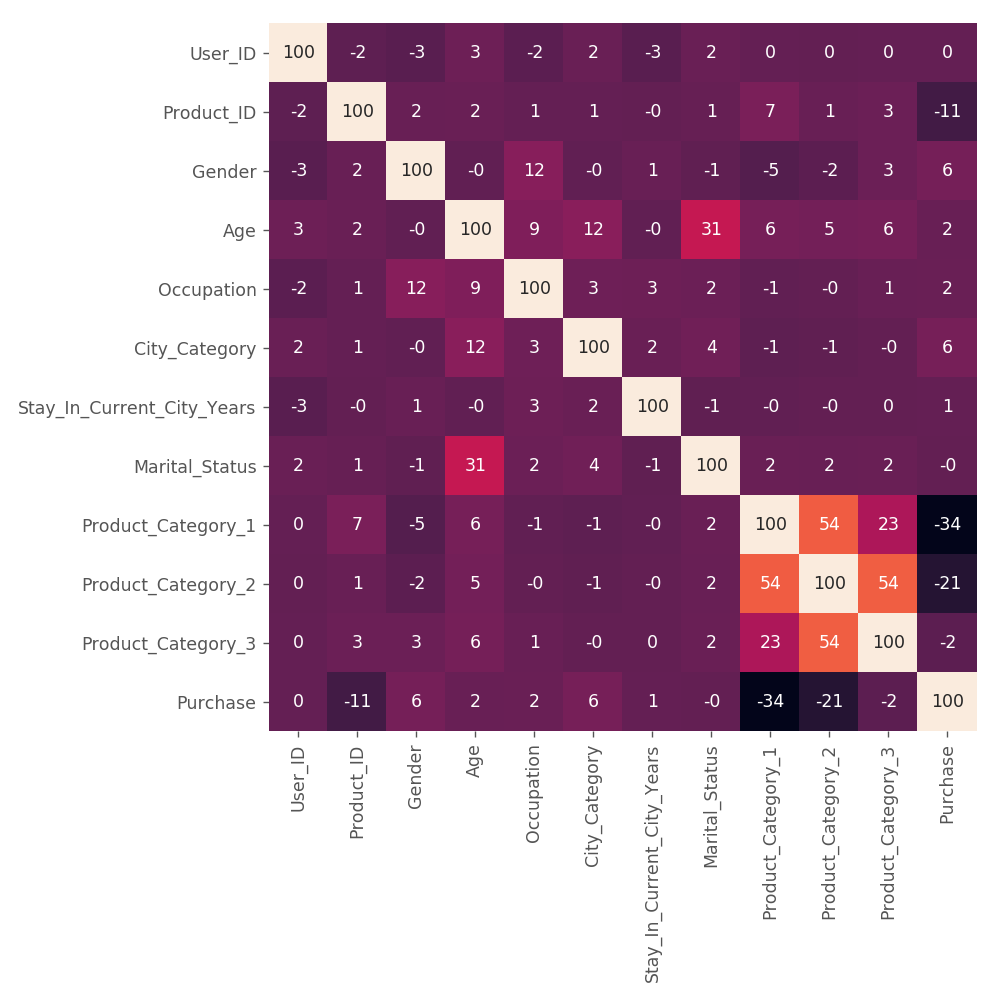

In [3]:
# start with a dataframe copy
df_cpy = df.copy()

# all data needs to be numeric to perform a correlation analysis
labels = []
col2encode = df.select_dtypes(['object']).columns
# convert non-numeric columns to numbers
for col in col2encode:
    # convert to category
    df_cpy[col] = df_cpy[col].astype('category')
    # save category names
    labels.append( (col, df_cpy[col].cat.categories) )
    # replace category name by numeric value
    df_cpy[col] = df_cpy[col].cat.codes

# make labels a dictionary
labels = dict(labels)
    
# keep matplotlib interactive
%matplotlib notebook
import matplotlib.pyplot as plt
# use ggplot style
plt.style.use('ggplot')

# show correlation via seaborn
import seaborn as sn
_ , axsn = plt.subplots(figsize=(8,8))
sn.heatmap(df_cpy.corr()*100, ax=axsn, square=False, fmt='.0f', annot=True, cbar=False)
# rotation represents the state of label's rotation (Note: doc says labelrotation but ignore it)
axsn.tick_params(axis = 'x',rotation = 90.0)
axsn.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

Product Category 1 and 2 seems to help predict purchase the most.  Product ID is third.

Regarding feature correlation, Product Category 1,2 and 3 should be combined as they are correlated with each other. Moreover there are missing values which can hold information.

Notice the following correlation too:<br>

* Age and Marital status is 31% correlated. (More likely yo be married if you are older) <br>
* Age and City category is 12% correlated. <br>
* Gender and Occupation is 12% correlated.<br>

Combine all product categories (1,2 and 3)

In [4]:
# combine Prod cat123 and add it to dataframe
temp_prod123 = df.Product_Category_1.astype(str) + '-' \
                + df.Product_Category_2.astype(str) + '-' \
                + df.Product_Category_3.astype(str)
df_cpy.insert(df_cpy.columns.get_loc('Product_Category_3')+1, 'Prod_cat123', temp_prod123)
# remove prod cat 1,2 and 3 from dataframe
df_cpy.drop(labels = ['Product_Category_1','Product_Category_2','Product_Category_3'], inplace=True, axis = 1)
# convert to category
temp = df_cpy['Prod_cat123'].astype('category')
# keep track of labels
labels['Prod_cat123'] = temp.cat.categories
# keep encoded values (code)
df_cpy['Prod_cat123'] = temp.cat.codes

Even out Age distribution prior to consolidating with Marital status

In [5]:
# even out age first (see Introduction and Data Exploration notebook)
df_cpy.Age = df.Age.replace(['0-17', '18-25'], '0-25')
df_cpy.Age.replace(['46-50', '51-55', '55+'], '46+', inplace = True)
df_cpy.Age.value_counts()

26-35    219587
0-25     114762
36-45    110013
46+      105706
Name: Age, dtype: int64

Age range 26-35 is still dominant but this is the best we can do unless we split it randomly in two parts or use Kmeans!

Combine Age and Marital Status

In [6]:
# Combine age (string recovered above) and marital status (it's a integer)
temp_age_mar = df_cpy.loc[:,['Age', 'Marital_Status']].astype(str)
temp_age_mar = temp_age_mar.Marital_Status + '-' + temp_age_mar.Age
df_cpy.insert(df_cpy.columns.get_loc('Marital_Status')+1, 'Marital_Status_Age', temp_age_mar)
df_cpy.drop(labels = ['Age','Marital_Status'], inplace=True, axis = 1)
labels.pop('Age')
# convert to category again
temp = df_cpy['Marital_Status_Age'].astype('category')
# keep track of labels
labels['Marital_Status_Age'] = temp.cat.categories
df_cpy['Marital_Status_Age'] = temp.cat.codes

Plot updated correlation

<IPython.core.display.Javascript object>


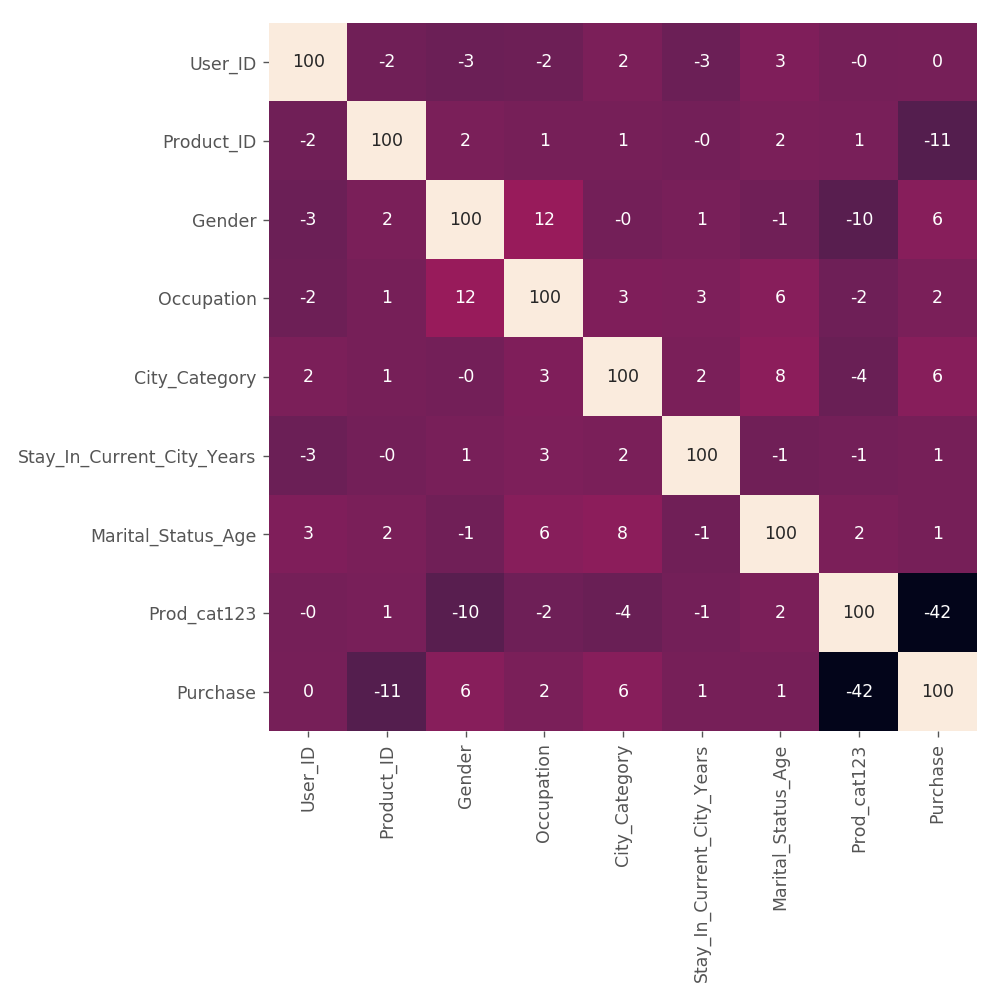

In [7]:
# show correlation again
_ , axsn2 = plt.subplots(figsize=(8,8))
sn.heatmap(df_cpy.corr()*100, ax=axsn2, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn2.tick_params(axis = 'x',rotation = 90.0)
axsn2.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

~~Combine Age, Marital Status and City Category (old idea)~~

In [8]:
# temp_Age_Marital_City_o = df_cpy.loc[:,['Age','Marital_Status', 'City_Category']].astype(str)
# # merge content of columns
# temp_Age_Marital_City_o = temp_Age_Marital_City_o.Age +'-'\
#         +temp_Age_Marital_City_o.Marital_Status +'-'\
#         +temp_Age_Marital_City_o.City_Category    
# # assign name to new column
# df_cpy.insert(len(df_cpy.columns)-2, 'Age_Marital_City', temp_Age_Marital_City_o)
# df_cpy.drop(labels = ['Age','Marital_Status','City_Category'],\
#               inplace=True, axis = 1)
# # convert to numeric values
# df_cpy['Age_Marital_City'] = df_cpy['Age_Marital_City'].astype('category').cat.codes

Even out stay in current city

In [9]:
# combine on original first
df_cpy.Stay_In_Current_City_Years = df.Stay_In_Current_City_Years.replace(['0', '1'], '0-1')
df_cpy.Stay_In_Current_City_Years.replace(['2', '3', '4+'], '2+', inplace = True)
df_cpy.Stay_In_Current_City_Years.value_counts()
temp = df_cpy['Stay_In_Current_City_Years'].astype('category')
# keep track of labels
labels['Stay_In_Current_City_Years'] = temp.cat.categories
df_cpy['Stay_In_Current_City_Years'] = temp.cat.codes

As Gender and Product category 1,2,3 are somewhat correlated, combine them

In [10]:
# Combine Prod_cat123 and Gender. For Prod_cat123, it has to be converted back to string via category
temp_prod_cat123 = pd.Series(\
            pd.Categorical.from_codes(df_cpy.loc[:,'Prod_cat123'], labels['Prod_cat123'], ordered=False).astype(str))
temp_cpy_G_cat = df.Gender + '-' + temp_prod_cat123
df_cpy.insert(df_cpy.columns.get_loc('Prod_cat123')+1, 'Gender_Prod_cat123', temp_cpy_G_cat)

Later on when transforming data from the test set, it turns out there are unseen Gender-Prod_cat123 combination. That means encoder won't work. Consequently, I'm adding those unseen instances and assign them values from similar instances.

In [11]:
import numpy as np
# make all possible combination of Gender-Prodcat123 (Pandas, Numpy)
Prodcat123_u = temp_prod_cat123.unique()
Gender_u = df.Gender.unique()
# repeat for one and tile for the other
Prodcat123_list = np.tile(Prodcat123_u, Gender_u.shape[0])
Gender_list = Gender_u.repeat(Prodcat123_u.shape[0])
Combi_list = Gender_list + '-' + Prodcat123_list

# find out missing combinations (use series/dataframe and values, keep Prodcat123 category)
s_encoder_combi = pd.Series(df_cpy.Gender_Prod_cat123.unique(), name = 'Incomplete')
df_combi = pd.DataFrame(np.stack((Combi_list,Prodcat123_list), axis=1), columns = ['Complete', 'Prodcat123_list'])
df_merged = pd.concat([s_encoder_combi, df_combi], axis=1, join='outer')
df_missing_combi = df_merged.loc[~df_merged.Complete.isin(df_merged.Incomplete), ['Prodcat123_list', 'Complete']]

# find replacement for missing instance
df_missing_combi.Prodcat123_list = df_missing_combi.Prodcat123_list.astype(\
                                                'category', categories = labels['Prod_cat123']).cat.codes
df_miss = df_cpy[df_cpy.Prod_cat123.isin(df_missing_combi.Prodcat123_list)]
df_mode = df_miss.groupby(['Prod_cat123']).apply(lambda x: x.mode())
# Because df_mode has Nan values, it will change columns type to float where there is at still one Nan

# keep only the most signficant instance across all features
# select first row of each missing Prod_cat123 mode (level 2 indexes will be dropped by default)
df_mode_u = df_mode.xs(0, level=1)

# match df_mode_u types to df_cpy types
df_mode_u = df_mode_u.astype(df_cpy.dtypes.to_dict())

# Replace Gender_Prod_cat123 column to missing values
df_mode_u = pd.merge(df_mode_u, df_missing_combi, how='inner', \
         left_on=['Prod_cat123'], right_on=['Prodcat123_list'])
df_mode_u.drop(['Prodcat123_list','Gender_Prod_cat123'], axis = 1, inplace = True)
df_mode_u.rename(columns={'Complete': 'Gender_Prod_cat123'}, inplace = True)
# keep column order the same as df_cpy before concatenating
df_mode_u = df_mode_u.reindex(columns=df_cpy.columns)

# add replacement for missing instances to our training set
df_cpy = pd.concat( [df_cpy, df_mode_u], axis = 0 , ignore_index=True)

Encode Gender_Prod_cat123 for correlation analysis

In [12]:
# df_cpy.drop(labels = ['Gender','Prod_cat123'], inplace=True, axis = 1)
# labels.pop('Gender')
# labels.pop('Prod_cat123')
# convert to numeric values
temp = df_cpy['Gender_Prod_cat123'].astype('category')
# keep track of labels
labels['Gender_Prod_cat123'] = temp.cat.categories
df_cpy['Gender_Prod_cat123'] = temp.cat.codes

Plot updated confusion matrix

<IPython.core.display.Javascript object>


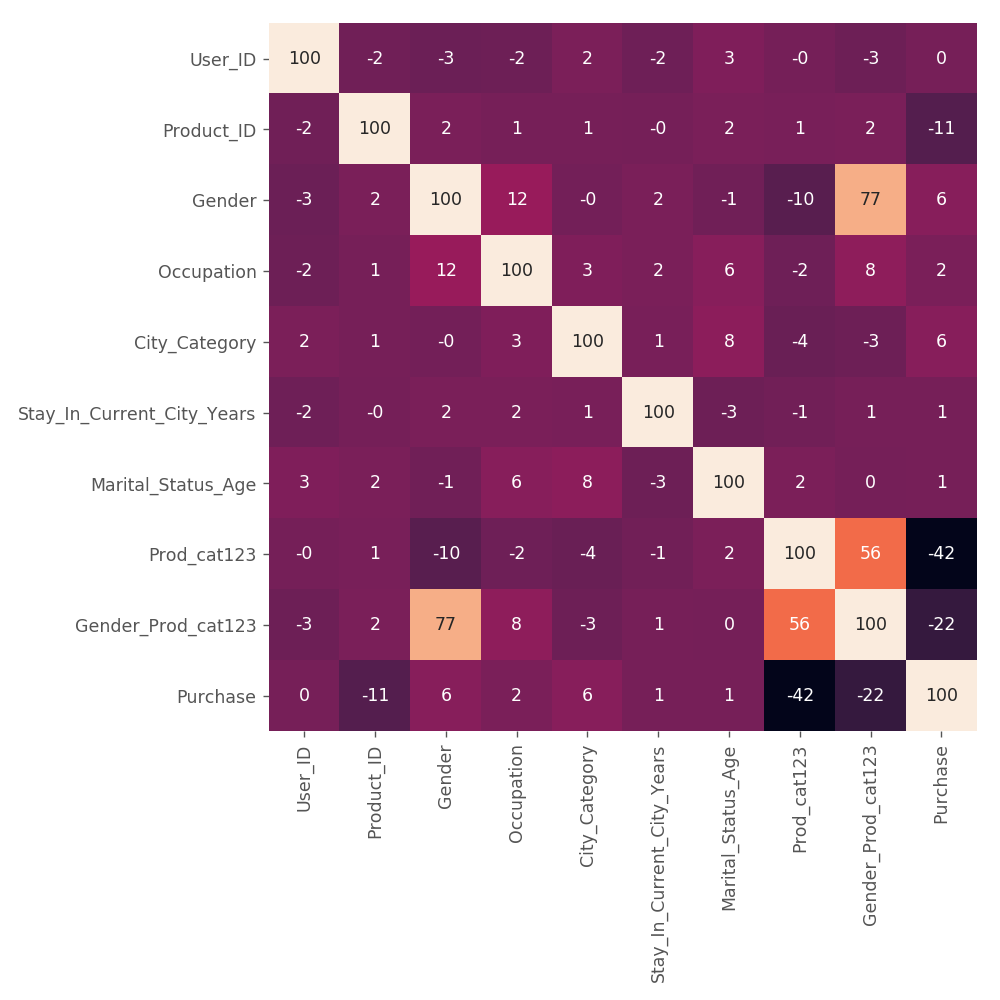

In [13]:
# show correlation
_ , axsn3 = plt.subplots(figsize=(8,8))
sn.heatmap(df_cpy.corr()*100, ax=axsn3, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn3.tick_params(axis = 'x',rotation = 90.0)
axsn3.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

### Proceed with one-hot encoding (All features are numeric now)

In [14]:
df_cpy.dtypes

User_ID                       int64
Product_ID                    int16
Gender                         int8
Occupation                    int64
City_Category                  int8
Stay_In_Current_City_Years     int8
Marital_Status_Age             int8
Prod_cat123                   int16
Gender_Prod_cat123            int16
Purchase                      int64
dtype: object

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder_dict = {}
X_features = {}

feature_names = df_cpy.columns.tolist()[:-1]
for f in feature_names:
    # OneHotEncoder() outputs sparse matrix by default
    this_encoder = OneHotEncoder()
    # populate X_features dict with sparse matrix
    X_features[f] = this_encoder.fit_transform(df_cpy.loc[:,f].values.reshape(-1,1))
    # keep encoder
    encoder_dict[f] = this_encoder
    

### Save One-hot encoded features to file (which includes feature names)

In [16]:
import pickle
pickle.dump( X_features, open( "./data/processed/Onehotfeatures.pkl", "wb" ) )

### Save labels and encoders  (to apply on test data later)

In [17]:
pickle.dump( encoder_dict, open( "./data/Onehotencoders.pkl", "wb" ) )
pickle.dump( labels, open( "./data/Category_encoders.pkl", "wb" ) )

### Save targets

In [18]:
# save target too
from numpy import save
save('./data/processed/target.npy', df_cpy.Purchase.values, allow_pickle=True, fix_imports=True)

### Save our new dataframe
We will need our <u> modified </u> dataframe later. Note that for categorical features, we need to revert back to string otherwise we will be left with encoded numbers.

In [19]:
for k in labels.keys():
    df_cpy.loc[:,k] = pd.Categorical.from_codes(df_cpy.loc[:,k], labels[k], ordered=False).astype(str)

In [20]:
df_cpy.to_pickle('./data/interim/DataframeMod.bz2')

# Extra: Does each Product ID refer to a unique product category?
We decided to combine Product Category 1,2 and 3. This is a sanity check to make sure the same product ID was NOT given 2 different product category 123.

In [21]:
# Group by product ID and see if each Product ID occurrence has a unique Product category triplet
df_ProdIDCat = pd.concat([df_cpy.loc[:,'Product_ID'], df_cpy.loc[:,'Prod_cat123']], axis=1)
# group by Prod ID then count the different Prod cat123 triplet for each Prod ID
s = df_ProdIDCat.groupby(['Product_ID']).Prod_cat123.value_counts()
# s has two levels of indexes (MultiIndex), Product_ID and Prod_cat123
s.head()

Product_ID  Prod_cat123
P00000142   3-4.0-5.0      1152
P00000242   2-4.0-9.0       376
P00000342   5-14.0-nan      244
P00000442   5-8.0-nan        92
P00000542   5-nan-nan       149
Name: Prod_cat123, dtype: int64

In [22]:
# compare number of Product_ID indexes (first level) to number of Prod_cat123 indexes (second level)
print('Number of distinct Product ID = {}'.format( len(s.index.get_level_values(0)) ))
print('Number of distinct Product Category123 = {}'.format( len(s.index.get_level_values(1)) ))

# NOTE: get_level_values()  returns a Int64Index object, len() and .shape work on it.
# Reminder: List uses len(), numpy array uses .shape for dimensionality

# # EXTRA: filter df_ProdIDCat by product (too slow!)
# for ind, ID in df.Product_ID.value_counts().iteritems():
#     if df_ProdIDCat[df_ProdIDCat.Product_ID == ID].Product_Cat123.value_counts().size > 1:
#         print(ind,ID)

Number of distinct Product ID = 3631
Number of distinct Product Category123 = 3631


Conclusion is each product ID belongs to a unique Prod Cat123